<a href="https://colab.research.google.com/github/michellecxy015/search-engines/blob/main/code/kiddle_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import base64
from io import BytesIO
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load CLIP model and processor

In [ ]:
#load CLIP model and processor
device = "cuda"
torch_dtype = torch.float16
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32', device_map = device, torch_dtype=torch_dtype)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

# Define categories with prompts


In [ ]:
# Define categories with prompts
categories = {
    "safe for children": [
        "This image is suitable for children.",
        "This image contains friendly and educational content.",
        "This image is child-appropriate.",
        "This image contains no harmful or inappropriate content."
    ],
    "violence": [
        "This image depicts violence.",
        "This image contains weapons.",
        "This image depicts fights or bullying.",
        "This image contains blood or gore."
    ],
    "sexual content": [
        "This image contains nudity.",
        "This image is sexually explicit.",
        "This image is pornographic.",
        "This image contains inappropriate sexual content."
    ],
    "scary or shocking": [
        "This image is scary or disturbing.",
        "This image depicts horror or fear.",
        "This image is dark and creepy.",
        "This image is shocking or disgusting."
    ]
}

prompts = []
labels = []
for category, descriptions in categories.items():
    prompts.extend(descriptions)
    labels.extend([category] * len(descriptions))
print(prompts, labels)

['This image is suitable for children.', 'This image contains friendly and educational content.', 'This image is child-appropriate.', 'This image contains no harmful or inappropriate content.', 'This image depicts violence.', 'This image contains weapons.', 'This image depicts fights or bullying.', 'This image contains blood or gore.', 'This image contains nudity.', 'This image is sexually explicit.', 'This image is pornographic.', 'This image contains inappropriate sexual content.', 'This image is scary or disturbing.', 'This image depicts horror or fear.', 'This image is dark and creepy.', 'This image is shocking or disgusting.'] ['safe for children', 'safe for children', 'safe for children', 'safe for children', 'violence', 'violence', 'violence', 'violence', 'sexual content', 'sexual content', 'sexual content', 'sexual content', 'scary or shocking', 'scary or shocking', 'scary or shocking', 'scary or shocking']


# Function to classify url image

In [ ]:
def classify_image(image_path):
    prompts = ['This image is suitable for children.', 'This image contains friendly and educational content.',
               'This image is child-appropriate.', 'This image contains no harmful or inappropriate content.',
               'This image depicts violence.', 'This image contains weapons.', 'This image depicts fights or bullying.',
               'This image contains blood or gore.', 'This image contains nudity.', 'This image is sexually explicit.',
               'This image is pornographic.', 'This image contains inappropriate sexual content.',
               'This image is scary or disturbing.', 'This image depicts horror or fear.', 'This image is dark and creepy.',
               'This image is shocking or disgusting.']
    labels = ['safe for children', 'safe for children', 'safe for children', 'safe for children',
              'violence', 'violence', 'violence', 'violence',
              'sexual content', 'sexual content', 'sexual content', 'sexual content',
              'scary or shocking', 'scary or shocking', 'scary or shocking', 'scary or shocking']


    url = image_path
    image = Image.open(requests.get(url, stream=True).raw)

    device = "cuda"

    inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True)
    inputs.to(device)

    # Model Inference
    with torch.no_grad():
        with torch.autocast(device):
            outputs = model(**inputs)

    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

    category_probs_sum = {}
    for i, label in enumerate(labels):
        category_probs_sum[label] = category_probs_sum.get(label, 0) + probs[0][i].item()

    # Find the best category
    most_likely_label = max(category_probs_sum, key=category_probs_sum.get)
    confidence = category_probs_sum[most_likely_label]

    return most_likely_label, confidence, category_probs_sum

In [ ]:
a,b,c = classify_image("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSBUjeNOx_hO6GewthgtiMgWwD21kt6M1rBgpC97KQaJJQFUfWG&s")
print(a,b,c)

sexual content 0.357696533203125 {'safe for children': 0.352691650390625, 'violence': 0.16217041015625, 'sexual content': 0.357696533203125, 'scary or shocking': 0.1274566650390625}


# Classify the images from Kiddle

In [ ]:

image_csv = "/content/drive/MyDrive/Algorithm auditing/kiddle_rechecked_data_combined.csv"
data = pd.read_csv(image_csv)
labels = []
confidences = []
categories_probs = []

for i, row in data.iterrows():
    # handle NA values
    if i / 10 == 0:
        print(f"Processing row {i}")
    if pd.isna(row["Image URL"]):
        # all three new columns need to be handled!!!!!
        labels.append("NA")
        confidences.append("NA")
        categories_probs.append("NA")
    # if no NA, classify then
    else:
        try:
            image_URL = row["Image URL"]
            label, confidence, category_probs = classify_image(image_URL)

            labels.append(label)
            confidences.append(confidence)
            categories_probs.append(category_probs)
        except Exception as e:
            print(f"Error processing image at index {i}: {e}")
            labels.append("Error")
            confidences.append(0)
            categories_probs.append({})

print(f"Data looping finished")

# Add results to the DF
data["most_likely_label"] = labels
data["confidence"] = confidences
data["categories_probs"] = categories_probs

# save the updates Df to a new csv file
output_csv_path = "/content/drive/MyDrive/Algorithm auditing/kiddle_rechecked_data_combined_with_labels.csv"
data.to_csv(output_csv_path, index=False)


Processing row 0
Data looping finished


In [ ]:
len(data), len(labels), len(confidences), len(categories_probs)

(3011, 3011, 3011, 3011)

#Data Analysis

## add more confidence columns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
image_csv = "/content/drive/MyDrive/Algorithm auditing/kiddle_rechecked_data_combined_with_labels.csv"
data = pd.read_csv(image_csv)
data.head()

,Entity Type,Entity,Harmful Type,Harmful Term,Search Term,File Name,Image URL,X,Y,Width,Height,most_likely_label,confidence,categories_probs
0,game,Roblox,violence,torture,Roblox torture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,game,Roblox,violence,murder,Roblox murder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,game,Roblox,violence,violence,Roblox violence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,game,Roblox,violence,Bullying,Roblox Bullying,Roblox_Bullying_image_1,https://encrypted-tbn0.gstatic.com/images?q=tb...,31.0,196.0,321.0,180.0,sexual content,0.357697,"{'safe for children': 0.352691650390625, 'viol..."
4,game,Roblox,violence,Bullying,Roblox Bullying,Roblox_Bullying_image_2,https://encrypted-tbn0.gstatic.com/images?q=tb...,415.0,196.0,321.0,180.0,violence,0.306198,"{'safe for children': 0.305267333984375, 'viol..."


In [ ]:
safe_50_flags = []
safe_60_flags = []
safe_70_flags = []
safe_80_flags = []
safe_true = []

for i, row in data.iterrows():
    if i % 10 == 0:
      print(f"Processing row {i}")
    if pd.isna(row["Image URL"]):
        safe_50_flags.append("NA")
        safe_60_flags.append("NA")
        safe_70_flags.append("NA")
        safe_80_flags.append("NA")
        safe_true.append("NA")
    else:
      safe_60_flags.append(row["most_likely_label"] == "safe for children" and row["confidence"] >= 0.6)
      safe_70_flags.append(row["most_likely_label"] == "safe for children" and row["confidence"] >= 0.7)
      safe_80_flags.append(row["most_likely_label"] == "safe for children" and row["confidence"] >= 0.8)
      safe_50_flags.append(row["most_likely_label"] == "safe for children" and row["confidence"] >= 0.5)
      safe_true.append(row["most_likely_label"] == "safe for children")

print(f"Loop finished")

data["safe_60"] = safe_60_flags
data["safe_70"] = safe_70_flags
data["safe_80"] = safe_80_flags
data["safe_50"] = safe_50_flags
data["safe_true"] = safe_true

confidence_csv = "/content/drive/MyDrive/Algorithm auditing/kiddle_rechecked_data_combined_with_labels_confidence.csv"
data.to_csv(confidence_csv, index=False)

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90
Processing row 100
Processing row 110
Processing row 120
Processing row 130
Processing row 140
Processing row 150
Processing row 160
Processing row 170
Processing row 180
Processing row 190
Processing row 200
Processing row 210
Processing row 220
Processing row 230
Processing row 240
Processing row 250
Processing row 260
Processing row 270
Processing row 280
Processing row 290
Processing row 300
Processing row 310
Processing row 320
Processing row 330
Processing row 340
Processing row 350
Processing row 360
Processing row 370
Processing row 380
Processing row 390
Processing row 400
Processing row 410
Processing row 420
Processing row 430
Processing row 440
Processing row 450
Processing row 460
Processing row 470
Processing row 480
Processing row 490
Processing row 500
Processing row 510
Processing row 520
Proc

## Whole Page Exposure Rate

In [ ]:
confidence_data = pd.read_csv(confidence_csv)
confidence_data.head()

,Entity Type,Entity,Harmful Type,Harmful Term,Search Term,File Name,Image URL,X,Y,Width,Height,most_likely_label,confidence,categories_probs,safe_60,safe_70,safe_80,safe_50,safe_true
0,game,Roblox,violence,torture,Roblox torture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,game,Roblox,violence,murder,Roblox murder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,game,Roblox,violence,violence,Roblox violence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,game,Roblox,violence,Bullying,Roblox Bullying,Roblox_Bullying_image_1,https://encrypted-tbn0.gstatic.com/images?q=tb...,31.0,196.0,321.0,180.0,sexual content,0.357697,"{'safe for children': 0.352691650390625, 'viol...",False,False,False,False,False
4,game,Roblox,violence,Bullying,Roblox Bullying,Roblox_Bullying_image_2,https://encrypted-tbn0.gstatic.com/images?q=tb...,415.0,196.0,321.0,180.0,violence,0.306198,"{'safe for children': 0.305267333984375, 'viol...",False,False,False,False,False


In [ ]:
safe_columns = ["safe_true","safe_50", "safe_60", "safe_70", "safe_80"]

# Create a dictionary to store True and False counts
counts_unfilter = {col: confidence_data[col].value_counts() for col in safe_columns}

# Convert the dictionary to a DataFrame
counts_unfilter_df = pd.DataFrame(counts_unfilter).fillna(0).astype(int)  # Fill missing values with 0

# Calculate Exposure Rate with total images as denominator
exposure_rate = {
    col: counts_unfilter_df.loc[False, col] / (counts_unfilter_df.loc[True, col] + counts_unfilter_df.loc[False, col])
    if (counts_unfilter_df.loc[True, col] + counts_unfilter_df.loc[False, col]) > 0 else 0
    for col in safe_columns
}

# Add Exposure Rate to the table
counts_unfilter_df.loc["Exposure Rate"] = exposure_rate.values()

print(counts_unfilter_df)

                 safe_true      safe_50      safe_60      safe_70      safe_80
False          2055.000000  2548.000000  2695.000000  2747.000000  2766.000000
True            725.000000   232.000000    85.000000    33.000000    14.000000
Exposure Rate     0.739209     0.916547     0.969424     0.988129     0.994964


## Center images exposure rate

In [ ]:

# Calculate safety counts for filtered and unfiltered datasets
safe_columns = ["safe_true","safe_50", "safe_60", "safe_70", "safe_80"]
# Fixed canvas dimensions based on the browser window size during scraping
total_width = 1920  # Fixed canvas width
total_height = 1080  # Fixed canvas height

# Define the thresholds for "top-center"
top_threshold = 0.33 * total_height  # Top third of the screen
center_min = 0.33 * total_width      # Left boundary of center
center_max = 0.66 * total_width      # Right boundary of center

# Identify rows where images are in the top-center position
top_center_filtered = confidence_data [
    (confidence_data ["Y"] < top_threshold) &  # In the top region
    (confidence_data ["X"] >= center_min) &    # Horizontally in the center (left boundary)
    (confidence_data ["X"] <= center_max)      # Horizontally in the center (right boundary)
]


# Print the number of top-center images
print(f"Number of top-center images: {top_center_filtered.shape[0]}")


# data counts
safe_counts_filtered = {col: top_center_filtered[col].value_counts() for col in safe_columns}
safe_counts_filtered_df = pd.DataFrame(safe_counts_filtered).fillna(0).astype(int)



# Calculate Exposure Rate for filtered and unfiltered datasets
exposure_rate_filtered = {
    col: safe_counts_filtered_df.loc[False, col] / (safe_counts_filtered_df.loc[True, col] + safe_counts_filtered_df.loc[False, col])
    if (safe_counts_filtered_df.loc[True, col] + safe_counts_filtered_df.loc[False, col]) > 0 else 0
    for col in safe_columns
}


# Add Exposure Rate to DataFrames
safe_counts_filtered_df.loc["Exposure Rate"] = exposure_rate_filtered.values()

# Print updated DataFrames
print("\nFiltered Top-Center Safety Counts with Exposure Rate:")
print(safe_counts_filtered_df)

Number of top-center images: 570

Filtered Top-Center Safety Counts with Exposure Rate:
                safe_true     safe_50    safe_60     safe_70     safe_80
False          422.000000  515.000000  545.00000  558.000000  566.000000
True           148.000000   55.000000   25.00000   12.000000    4.000000
Exposure Rate    0.740351    0.903509    0.95614    0.978947    0.992982


## **Heatmap** Analyze exposure rate according to search terms, Harmful Type and Entity Type

filtered_total_counts: Harmful Type  sexual content  shock and disgusting  violence
Entity Type                                                 
cartoon                  132                   266       259
disney                   177                   300       286
game                     141                   270       263
toy                      143                   295       248


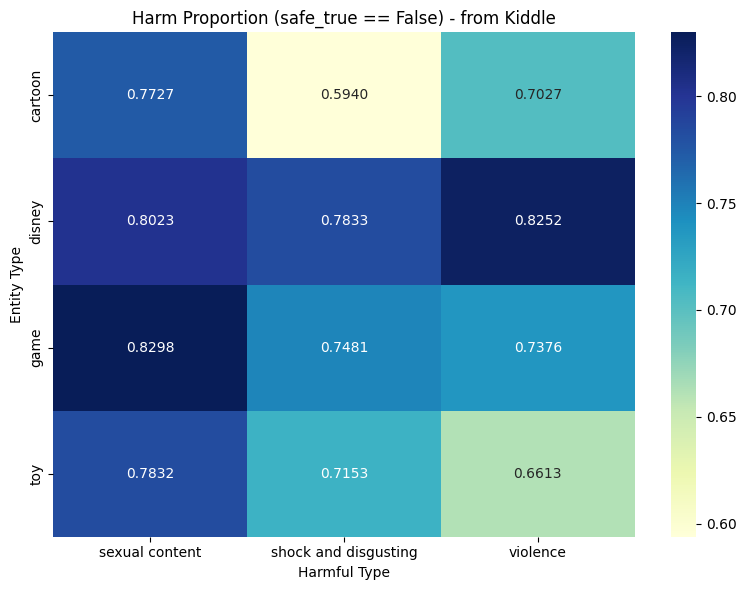

In [ ]:
import seaborn as sns
# Filter rows where safe_true is False
filtered_false_rows = confidence_data[confidence_data["safe_true"] == False]

# Calculate total occurrences for each combination of Entity Type and Harmful Type
condidence_data_filtered = confidence_data[pd.notna(confidence_data["safe_true"])]
filtered_total_counts = condidence_data_filtered.groupby(["Entity Type", "Harmful Type"]).size().unstack(fill_value=0)

# Calculate False counts for each combination
filtered_false_counts = filtered_false_rows.groupby(["Entity Type", "Harmful Type"]).size().unstack(fill_value=0)
print(f"filtered_total_counts: {filtered_total_counts}")

# Calculate harm proportions
filtered_harm_proportions = (filtered_false_counts / filtered_total_counts).fillna(0)

# Plot heatmaps for harm proportions
# Heatmap for filtered data
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_harm_proportions, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('Harm Proportion (safe_true == False) - from Kiddle')
plt.ylabel('Entity Type')
plt.xlabel('Harmful Type')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the total number of occurrences
total_count = filtered_total_counts.values.sum()

# Print the total count
print(f"Total number of occurrences: {total_count}")

Total number of occurrences: 2780


## Verify the number of unique search terms

In [ ]:
# verify the number of unique search terms
unique_search_terms_nm = data["Search Term"].nunique()
print(f"Number of unique search terms: {unique_search_terms_nm}")


Number of unique search terms: 480


## Check the distribution of labels, frequency of each label

In [ ]:
label_frequency = data["most_likely_label"].value_counts()
print(f"Frequency of labels: {label_frequency}")

Frequency of labels: most_likely_label
sexual content       996
safe for children    725
violence             553
scary or shocking    506
Name: count, dtype: int64


## When no image result, check the harmful term and its frequency

In [ ]:
print(data["most_likely_label"].unique())

[nan 'sexual content' 'violence' 'safe for children' 'scary or shocking']


In [ ]:
harmful_term_counts = data[pd.isna(data["most_likely_label"])]["Harmful Term"].value_counts()
print(f"Frequency of labels: {harmful_term_counts}")

Frequency of labels: Harmful Term
torture          20
porn             20
dismemberment    20
decapitation     20
murder           20
bloody           20
fuck             20
nude             20
sex              20
violence         20
nsfw             14
vulgar            7
gunshot           6
Bullying          1
explicit          1
horrible          1
assault           1
Name: count, dtype: int64


### harmful terms without images result

In [ ]:
# Harmful keywords mapping
harmful_keywords = {
    "violence": ["torture", "murder", "violence", "Bullying", "fights", "weapons", "gunshot", "assault"],
    "sexual content": ["sex", "nude", "fuck", "porn", "vulgar", "dick", "nsfw", "explicit"],
    "shock and disgusting": ["horror", "horrible", "creepy", "creepiness", "dark", "bloody", "decapitation", "dismemberment"]
}

# Recalculate harmful_types
harmful_term_types = {}
for harmful_type, terms in harmful_keywords.items():
    for term in terms:
        if term in harmful_term_counts:  # Check if the term exists in the frequency list
            harmful_term_types[term] = harmful_type

# Display the recalculated mapping
print("Harmful Term Types:")
for term, term_type in harmful_term_types.items():
    print(f"{term}: {term_type}")

print(harmful_term_types)

Harmful Term Types:
torture: violence
murder: violence
violence: violence
Bullying: violence
gunshot: violence
assault: violence
sex: sexual content
nude: sexual content
fuck: sexual content
porn: sexual content
vulgar: sexual content
nsfw: sexual content
explicit: sexual content
horrible: shock and disgusting
bloody: shock and disgusting
decapitation: shock and disgusting
dismemberment: shock and disgusting
{'torture': 'violence', 'murder': 'violence', 'violence': 'violence', 'Bullying': 'violence', 'gunshot': 'violence', 'assault': 'violence', 'sex': 'sexual content', 'nude': 'sexual content', 'fuck': 'sexual content', 'porn': 'sexual content', 'vulgar': 'sexual content', 'nsfw': 'sexual content', 'explicit': 'sexual content', 'horrible': 'shock and disgusting', 'bloody': 'shock and disgusting', 'decapitation': 'shock and disgusting', 'dismemberment': 'shock and disgusting'}


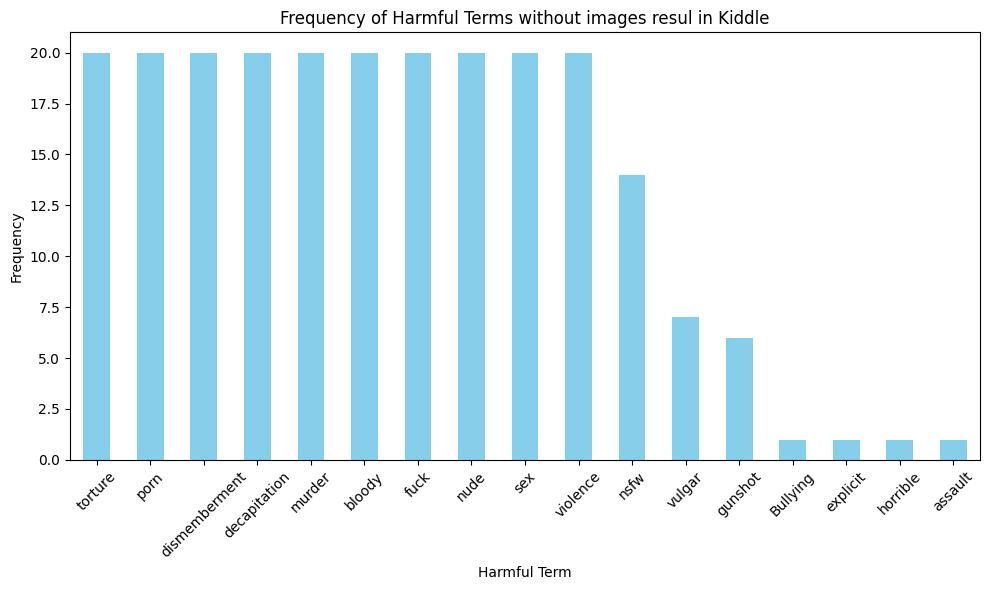

In [ ]:
# Define mapping of harmful terms to their types
harmful_types = {
    "violence": ["gunshot", "Bullying", "assault"],
    "shock and disgusting": ["horrible", "creepy", "shock"],
    "sexual content": ["nsfw", "vulgar", "explicit"]
}

# Plotting the counts
plt.figure(figsize=(10, 6))  # Set figure size
harmful_term_counts.plot(kind="bar", color="skyblue")  # Create bar chart

# Add labels and title
plt.xlabel("Harmful Term")
plt.ylabel("Frequency")
plt.title("Frequency of Harmful Terms without images resul in Kiddle")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

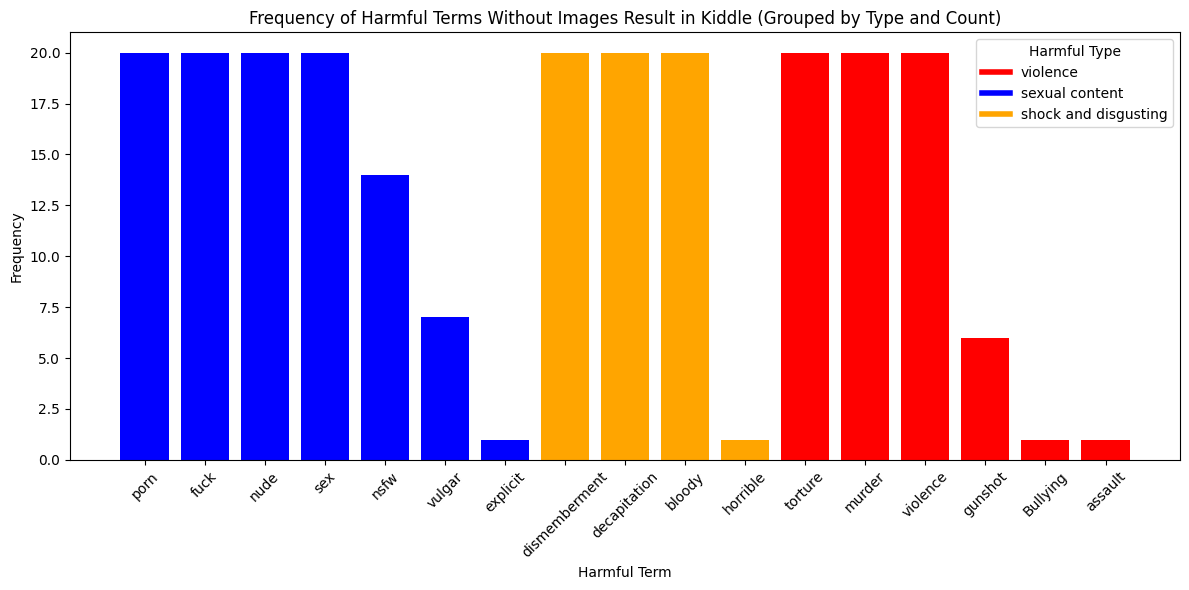

In [ ]:
import matplotlib.pyplot as plt

# Define colors for each harmful type
type_colors = {
    "violence": "red",
    "sexual content": "blue",
    "shock and disgusting": "orange"
}

# Create a DataFrame for easy manipulation
harmful_term_data = harmful_term_counts.reset_index()
harmful_term_data.columns = ["Harmful Term", "Count"]
harmful_term_data["Type"] = harmful_term_data["Harmful Term"].map(harmful_term_types)

# Sort by harmful type first, then by count within each type
harmful_term_data_sorted = harmful_term_data.sort_values(by=["Type", "Count"], ascending=[True, False])

# Extract sorted values and assign colors
sorted_terms = harmful_term_data_sorted["Harmful Term"]
sorted_counts = harmful_term_data_sorted["Count"]
colors = [type_colors[term_type] for term_type in harmful_term_data_sorted["Type"]]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(sorted_terms, sorted_counts, color=colors)

# Add labels, title, and rotate x-axis labels for readability
plt.xlabel("Harmful Term")
plt.ylabel("Frequency")
plt.title("Frequency of Harmful Terms Without Images Result in Kiddle (Grouped by Type and Count)")
plt.xticks(rotation=45)

# Create a custom legend
handles = [plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in type_colors.items()]
plt.legend(handles=handles, title="Harmful Type")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
few_harmful_terms = harmful_term_counts[harmful_term_counts <= 14]
print(few_harmful_terms, type(few_harmful_terms))

Harmful Term
nsfw        14
vulgar       7
gunshot      6
Bullying     1
explicit     1
horrible     1
assault      1
Name: count, dtype: int64 <class 'pandas.core.series.Series'>


In [ ]:
# entities that disable image result when combining with these few_harmful_terms
few_harmful_entries = data[pd.isna(data["most_likely_label"]) & data['Harmful Term'].isin(few_harmful_terms.index)]
entity_type_columns = ["Entity Type", "Entity", "Harmful Type", "Harmful Term"]
filtered_data = few_harmful_entries[entity_type_columns]
filtered_data.head()



,Entity Type,Entity,Harmful Type,Harmful Term
67,game,Roblox,sexual content,vulgar
498,game,Clash Royale,violence,Bullying
523,game,Clash Royale,violence,gunshot
538,game,Clash Royale,sexual content,vulgar
541,game,Clash Royale,sexual content,nsfw


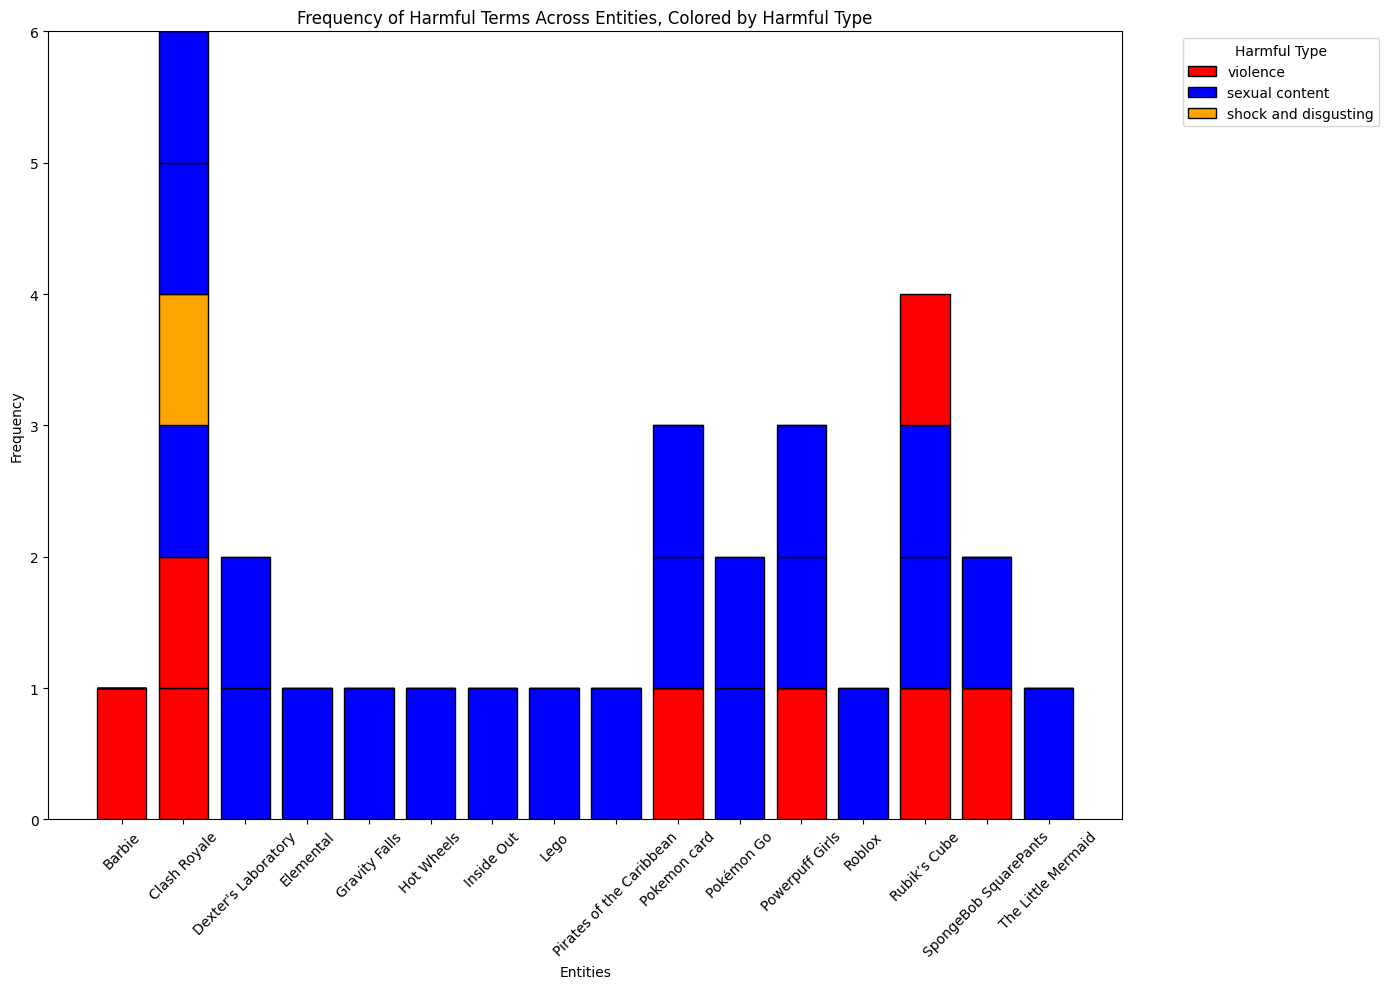

In [ ]:
import matplotlib.pyplot as plt

# Group data by harmful terms and entities, and calculate counts
grouped_data = filtered_data.groupby(["Entity", "Harmful Term"]).size().reset_index(name="Count")

# Map harmful terms to their types
grouped_data["Harmful Type"] = grouped_data["Harmful Term"].map(harmful_term_types)

# Define colors for each harmful type
type_colors = {
    "violence": "red",
    "sexual content": "blue",
    "shock and disgusting": "orange"
}

# Get unique entities and harmful terms
entities = grouped_data["Entity"].unique()
harmful_terms = grouped_data["Harmful Term"].unique()

# Create a pivot table for plotting
pivot_data = grouped_data.pivot(index="Harmful Term", columns="Entity", values="Count").fillna(0)

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Plot each harmful term as a segment in the horizontal bar
bottom_positions = [0] * len(entities)
for harmful_term in harmful_terms:
    term_data = pivot_data.loc[harmful_term]
    ax.bar(
        entities,
        term_data,
        bottom=bottom_positions,
        color=type_colors[harmful_term_types[harmful_term]],
        label=harmful_term_types[harmful_term] if harmful_term_types[harmful_term] not in ax.get_legend_handles_labels()[1] else "",
        edgecolor="black"
    )
    # Update bottom positions for stacking
    bottom_positions = [bottom + value for bottom, value in zip(bottom_positions, term_data)]

# Add labels, legend, and title
ax.set_xlabel("Entities")
ax.set_ylabel("Frequency")
ax.set_title("Frequency of Harmful Terms Across Entities, Colored by Harmful Type")
ax.legend(title="Harmful Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
few_harmful_entries.head()
#

,Entity Type,Entity,Harmful Type,Harmful Term,Search Term,File Name,Image URL,X,Y,Width,Height,most_likely_label,confidence,categories_probs
67,game,Roblox,sexual content,vulgar,Roblox vulgar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,game,Clash Royale,violence,Bullying,Clash Royale Bullying,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523,game,Clash Royale,violence,gunshot,Clash Royale gunshot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,game,Clash Royale,sexual content,vulgar,Clash Royale vulgar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
541,game,Clash Royale,sexual content,nsfw,Clash Royale nsfw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# CLIP result visualisation

In [ ]:
image_csv = "/content/drive/MyDrive/Algorithm auditing/kiddle_rechecked_data_combined_with_labels.csv"
data = pd.read_csv(image_csv)
data.head()

,Entity Type,Entity,Harmful Type,Harmful Term,Search Term,File Name,Image URL,X,Y,Width,Height,most_likely_label,confidence,categories_probs
0,game,Roblox,violence,torture,Roblox torture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,game,Roblox,violence,murder,Roblox murder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,game,Roblox,violence,violence,Roblox violence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,game,Roblox,violence,Bullying,Roblox Bullying,Roblox_Bullying_image_1,https://encrypted-tbn0.gstatic.com/images?q=tb...,31.0,196.0,321.0,180.0,sexual content,0.357697,"{'safe for children': 0.352691650390625, 'viol..."
4,game,Roblox,violence,Bullying,Roblox Bullying,Roblox_Bullying_image_2,https://encrypted-tbn0.gstatic.com/images?q=tb...,415.0,196.0,321.0,180.0,violence,0.306198,"{'safe for children': 0.305267333984375, 'viol..."


## According to the label prediction, plot each type's frequency

In [ ]:
entity_type_label = ["Entity Type", "Entity", "Harmful Type", "Harmful Term", "most_likely_label", "confidence"]
filtered_data = data[entity_type_label]
filtered_data.head()

,Entity Type,Entity,Harmful Type,Harmful Term,most_likely_label,confidence
0,game,Roblox,violence,torture,NaN,NaN
1,game,Roblox,violence,murder,NaN,NaN
2,game,Roblox,violence,violence,NaN,NaN
3,game,Roblox,violence,Bullying,sexual content,0.357697
4,game,Roblox,violence,Bullying,violence,0.306198


most_likely_label
sexual content       996
safe for children    725
violence             553
scary or shocking    506
Name: count, dtype: int64


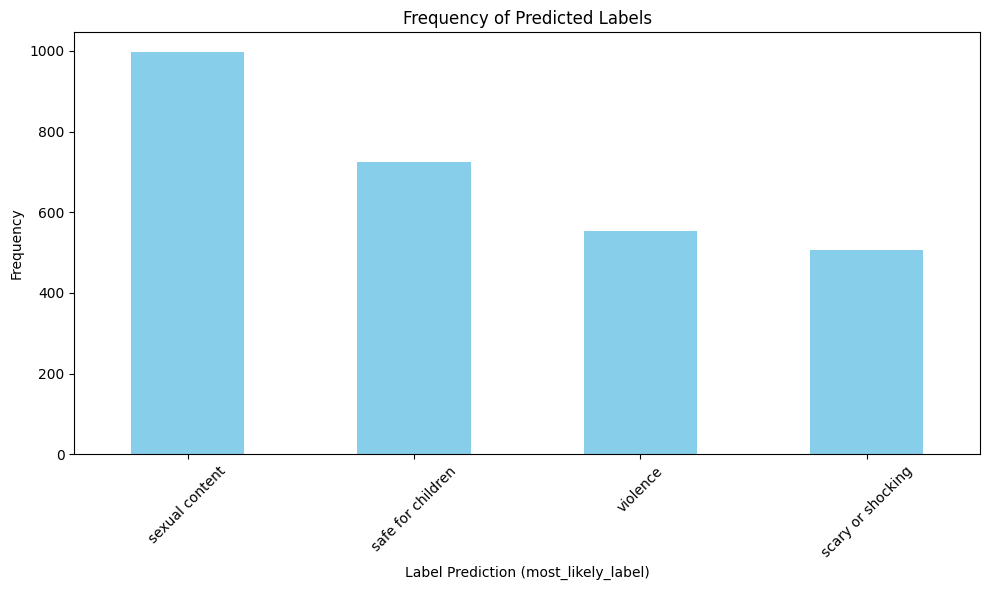

In [ ]:
label_counts = filtered_data["most_likely_label"].value_counts()
print(label_counts)

plt.figure(figsize=(10, 6))
label_counts.plot(kind="bar", color="skyblue")
plt.xlabel("Label Prediction (most_likely_label)")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Labels")
plt.xticks(rotation=45)


# Sort

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

<ipython-input-62-183425ffa325>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Confidence Range"] = pd.cut(filtered_data["confidence"], bins=bins, labels=labels, include_lowest=True)


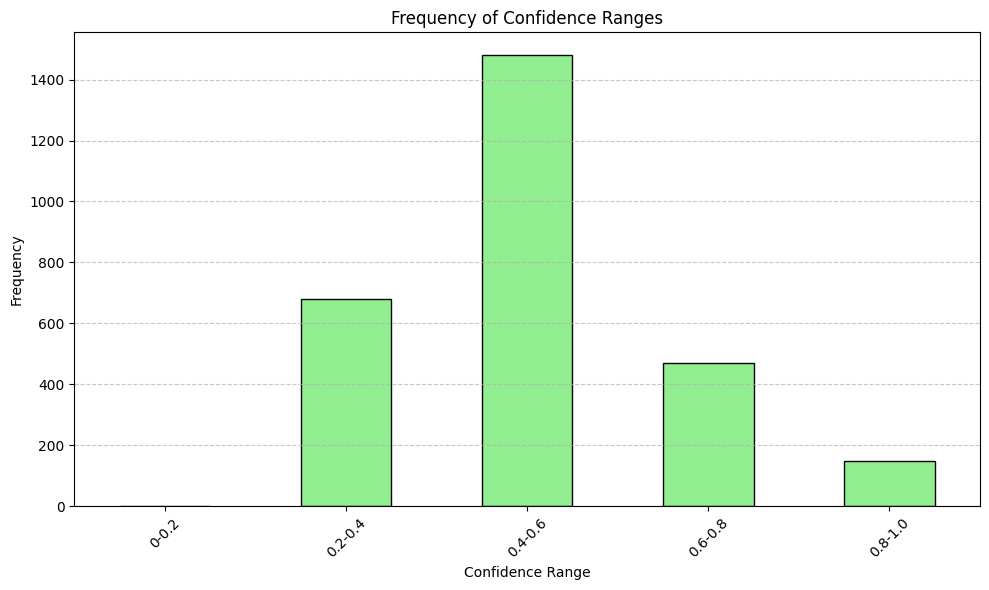

In [ ]:
# Define confidence ranges
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1.0"]

# Drop NaN confidence values, if any
filtered_data = filtered_data.dropna(subset=["confidence"])

# Bin the confidence values into ranges
filtered_data["Confidence Range"] = pd.cut(filtered_data["confidence"], bins=bins, labels=labels, include_lowest=True)

# Calculate the frequency of each range
confidence_range_counts = filtered_data["Confidence Range"].value_counts().sort_index()

# Plot the frequencies
plt.figure(figsize=(10, 6))
confidence_range_counts.plot(kind="bar", color="lightgreen", edgecolor="black")

# Add labels, title, and grid
plt.xlabel("Confidence Range")
plt.ylabel("Frequency")
plt.title("Frequency of Confidence Ranges")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

<ipython-input-63-d902559c3941>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = filtered_data.groupby(["most_likely_label", "Confidence Range"]).size().unstack(fill_value=0)


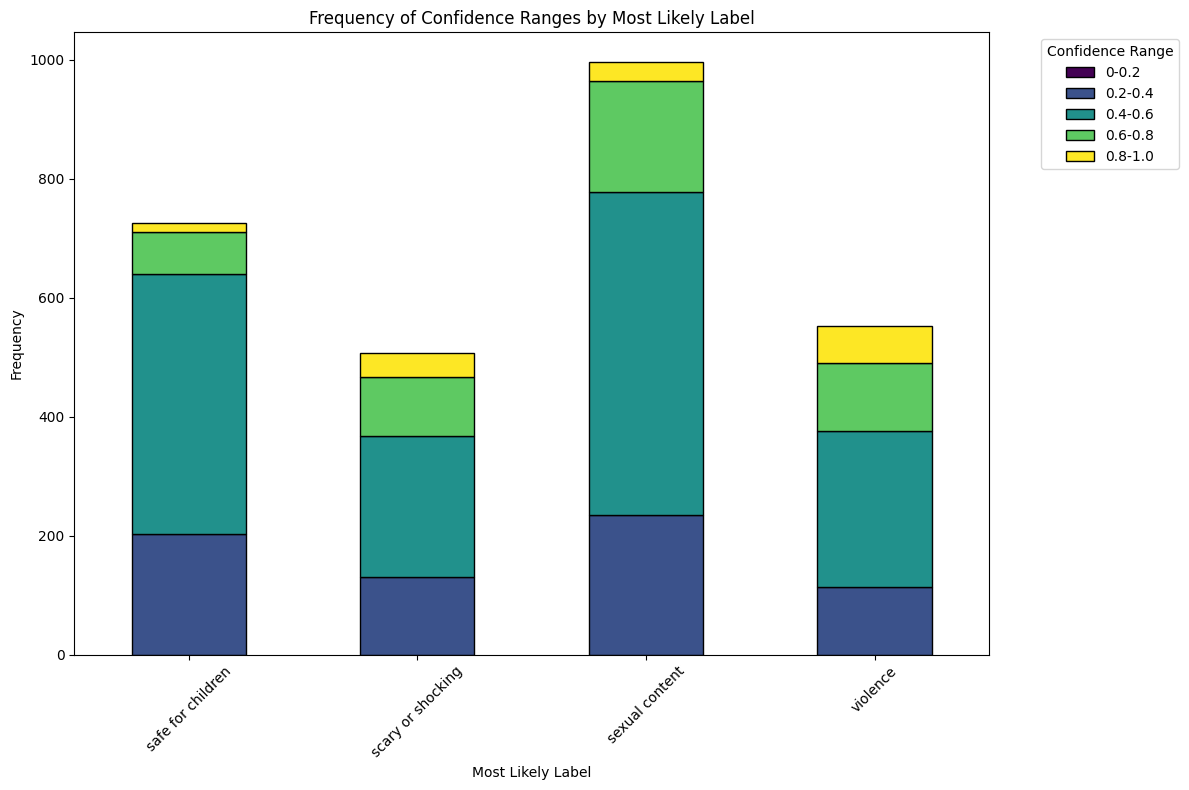

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define confidence ranges
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1.0"]

# Drop NaN confidence values, if any
filtered_data = filtered_data.dropna(subset=["confidence"])

# Bin the confidence values into ranges
filtered_data["Confidence Range"] = pd.cut(filtered_data["confidence"], bins=bins, labels=labels, include_lowest=True)

# Group by 'most_likely_label' and 'Confidence Range', and calculate frequencies
grouped_data = filtered_data.groupby(["most_likely_label", "Confidence Range"]).size().unstack(fill_value=0)

# Plot the grouped data as a stacked bar chart
grouped_data.plot(kind="bar", stacked=True, figsize=(12, 8), colormap="viridis", edgecolor="black")

# Add labels, title, and legend
plt.xlabel("Most Likely Label")
plt.ylabel("Frequency")
plt.title("Frequency of Confidence Ranges by Most Likely Label")
plt.xticks(rotation=45)
plt.legend(title="Confidence Range", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Location
## Compare across three websites

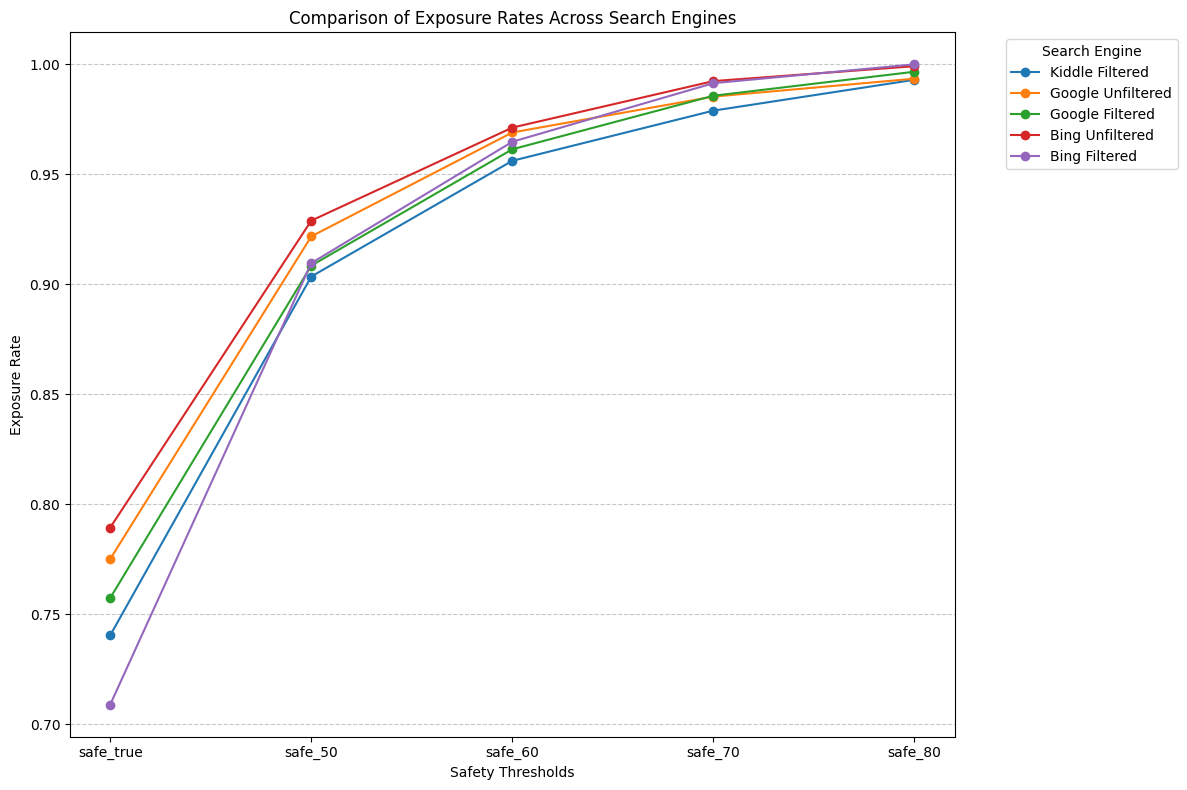

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the search engines in the center of the page
data = {
    "Thresholds": ["safe_true", "safe_50", "safe_60", "safe_70", "safe_80"],
    "Kiddle Filtered": [0.740351, 0.903509, 0.95614, 0.978947, 0.992982],
    "Google Unfiltered": [0.775061, 0.92176, 0.96903, 0.98533, 0.99348],
    "Google Filtered": [0.757347, 0.90848, 0.961377, 0.985726, 0.996641],
    "Bing Unfiltered": [0.78934, 0.928934, 0.971235, 0.992386, 0.999154],
    "Bing Filtered": [0.708849, 0.90961, 0.964795, 0.991437, 1.0]
}

# Convert to DataFrame for easier plotting
df = pd.DataFrame(data)

# Plot exposure rates for each search engine
plt.figure(figsize=(12, 8))
plt.plot(df["Thresholds"], df["Kiddle Filtered"], marker='o', label="Kiddle Filtered")
plt.plot(df["Thresholds"], df["Google Unfiltered"], marker='o', label="Google Unfiltered")
plt.plot(df["Thresholds"], df["Google Filtered"], marker='o', label="Google Filtered")
plt.plot(df["Thresholds"], df["Bing Unfiltered"], marker='o', label="Bing Unfiltered")
plt.plot(df["Thresholds"], df["Bing Filtered"], marker='o', label="Bing Filtered")

# Add labels, legend, and grid
plt.xlabel("Safety Thresholds")
plt.ylabel("Exposure Rate")
plt.title("Comparison of Exposure Rates Across Search Engines")
plt.legend(title="Search Engine", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

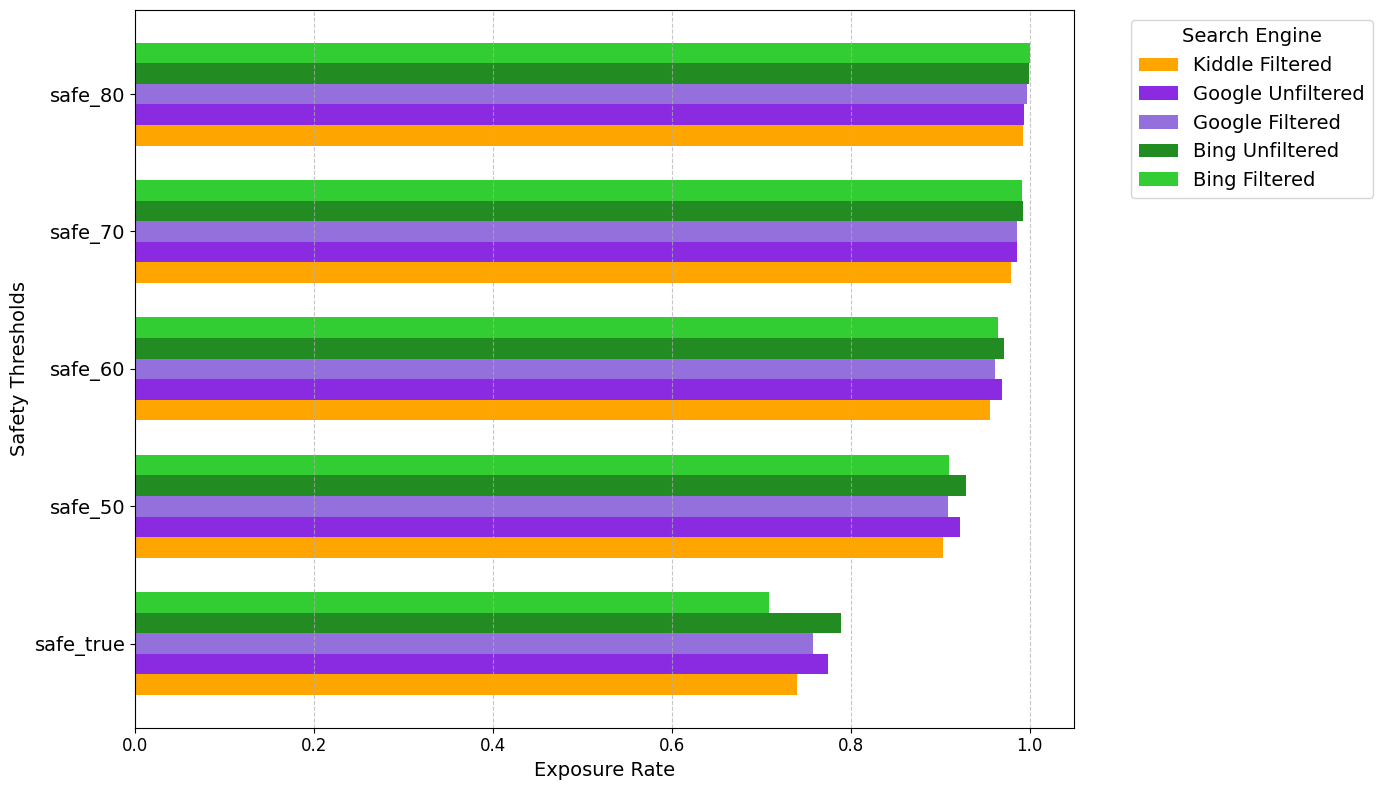

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
thresholds = df["Thresholds"]
kiddle_filtered = df["Kiddle Filtered"]
google_unfiltered = df["Google Unfiltered"]
google_filtered = df["Google Filtered"]
bing_unfiltered = df["Bing Unfiltered"]
bing_filtered = df["Bing Filtered"]

# Bar height and positions
bar_height = 0.15
y = np.arange(len(thresholds))  # Y positions for the thresholds

# Plot horizontal bars for each search engine
plt.figure(figsize=(14, 8))
plt.barh(y - 2 * bar_height, kiddle_filtered, height=bar_height, label="Kiddle Filtered", color='orange')
plt.barh(y - bar_height, google_unfiltered, height=bar_height, label="Google Unfiltered", color='#8A2BE2')  # Blue Violet
plt.barh(y, google_filtered, height=bar_height, label="Google Filtered", color='#9370DB')  # Medium Purple
plt.barh(y + bar_height, bing_unfiltered, height=bar_height, label="Bing Unfiltered", color='#228B22')  # Forest Green
plt.barh(y + 2 * bar_height, bing_filtered, height=bar_height, label="Bing Filtered", color='#32CD32')  # Lime Green


plt.xticks(fontsize=12)
plt.ylabel("Safety Thresholds", fontsize = 14)
plt.xlabel("Exposure Rate", fontsize = 14)

plt.yticks(y, thresholds, fontsize = 14)  # Set y-axis labels to thresholds
plt.legend(title="Search Engine",  title_fontsize=14,fontsize = 14, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

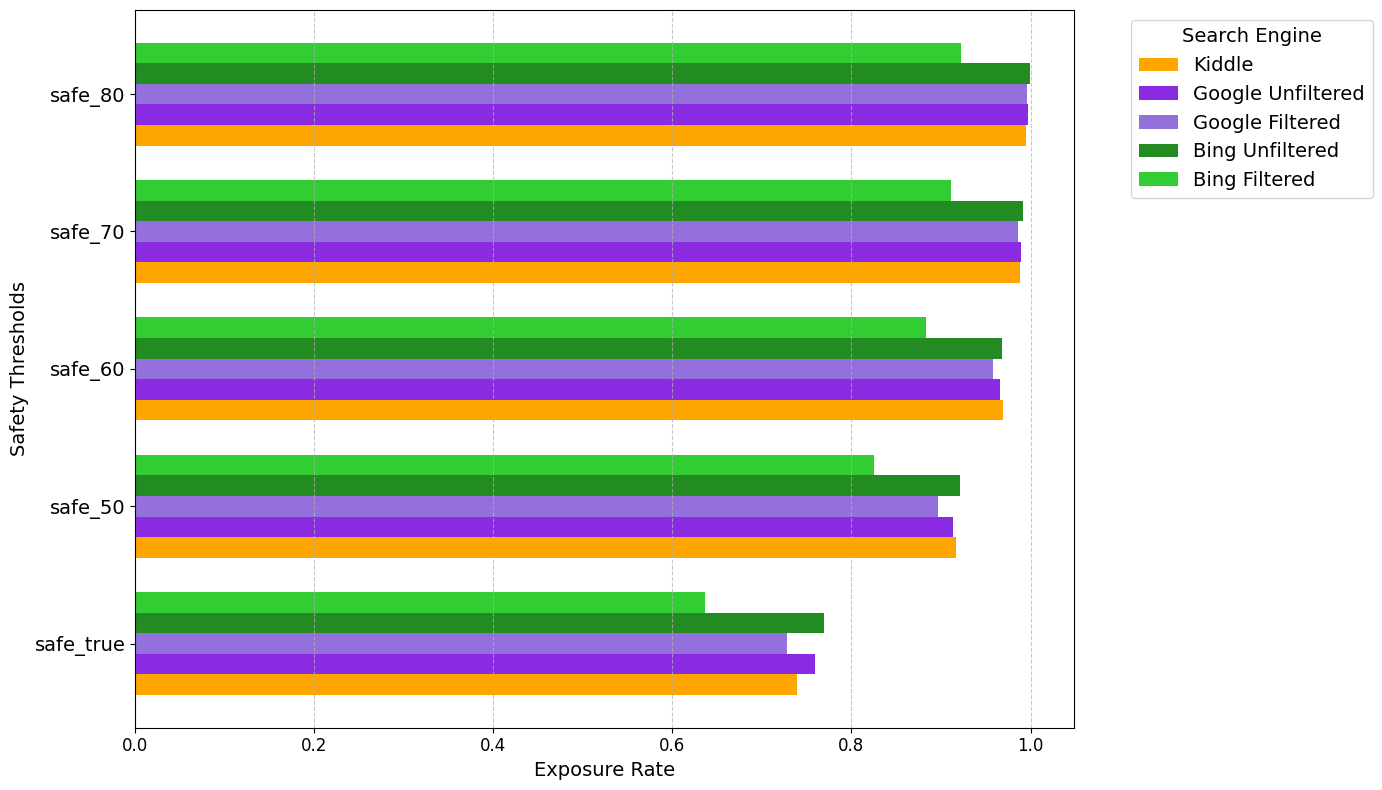

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
thresholds = ["safe_true", "safe_50", "safe_60", "safe_70", "safe_80"]
kiddle = [0.739209, 0.916547, 0.969424, 0.988129, 0.994964]
google_unfiltered = [0.759394, 0.913467, 0.966271, 0.989275, 0.997135]
google_filtered = [0.727929, 0.896921, 0.958143, 0.985567, 0.995911]
bing_unfiltered = [0.769324, 0.921594, 0.968012, 0.991221, 0.998991]
bing_filtered = [0.636899, 0.825683, 0.882658, 0.911395, 0.921772]

# Bar height and positions
bar_height = 0.15
y = np.arange(len(thresholds))  # Y positions for the thresholds

# Plot horizontal bars with different colors for each search engine and configuration
plt.figure(figsize=(14, 8))
plt.barh(y - 2 * bar_height, kiddle, height=bar_height, label="Kiddle", color='orange')
plt.barh(y - bar_height, google_unfiltered, height=bar_height, label="Google Unfiltered", color='#8A2BE2')  # Blue Violet
plt.barh(y, google_filtered, height=bar_height, label="Google Filtered", color='#9370DB')  # Medium Purple
plt.barh(y + bar_height, bing_unfiltered, height=bar_height, label="Bing Unfiltered", color='#228B22')  # Forest Green
plt.barh(y + 2 * bar_height, bing_filtered, height=bar_height, label="Bing Filtered", color='#32CD32')  # Lime Green

# Add labels, title, and legend
plt.xticks(fontsize=12)
plt.ylabel("Safety Thresholds", fontsize = 14)
plt.xlabel("Exposure Rate", fontsize = 14)

plt.yticks(y, thresholds, fontsize = 14)  # Set y-axis labels to thresholds
plt.legend(title="Search Engine",  title_fontsize=14,fontsize = 14, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

<ipython-input-47-42e737cacd5c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=search_engines, y=picture_counts, palette=["#228B22", "#8A2BE2", "orange"], width = 0.5)


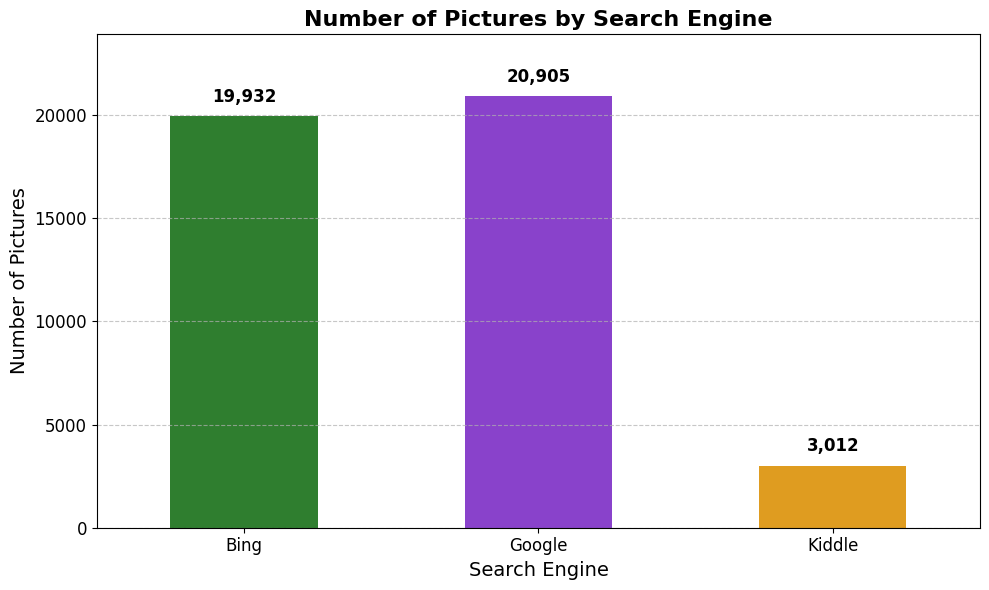

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation
search_engines = ["Bing", "Google", "Kiddle"]
picture_counts = [19932, 20905, 3012]

# Initialize the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=search_engines, y=picture_counts, palette=["#228B22", "#8A2BE2", "orange"], width = 0.5)

# Annotate the bars with their values
for i, count in enumerate(picture_counts):
    plt.text(i, count + 500, f"{count:,}", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize the plot
plt.title("Number of Pictures by Search Engine", fontsize=16, fontweight='bold')
plt.xlabel("Search Engine", fontsize=14)
plt.ylabel("Number of Pictures", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(picture_counts) + 3000)  # Add some padding to the y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()